# Hindi Named Entity Recognition on Weather Dataset

**Dataset from -** 
- https://medium.com/saarthi-ai/how-to-make-your-own-ner-model-with-contexual-word-embeddings-5086276e04a0

**Elmo Embeddings for Hindi from -**
- https://www.cse.iitb.ac.in/~pb/papers/sltu-ccurl20-il-we.pdf 
- https://www.cfilt.iitb.ac.in/~diptesh/embeddings/monolingual/contextual/ - hi.zip

**Refernces -**
- https://www.depends-on-the-definition.com/named-entity-recognition-with-residual-lstm-and-elmo/
- http://docs.allennlp.org/v0.9.0/api/allennlp.modules.elmo.html

**Importing libraries**

In [1]:
import numpy as np
import os
import pandas as pd
import re

**Setting data directory**  
Folder structure -   
- elmo_ner_hid512.ipynb  
- Data    
    nertrnweather.txt  
    nervalweather.txt  
- hi    
    elmo  
    hi-d512-elmo.hdf5  
    hi-d512-options.json  

In [2]:
data_dir = r'Data/'

**Dataset File Structure**

In [3]:
file = np.loadtxt(fname=data_dir+'nertrnweather.txt',encoding='utf-8',dtype=str)
file

array([['अरे', 'O'],
       ['सारथी', 'O'],
       ['जम्मू', 'U-location'],
       ...,
       ['क्या', 'O'],
       ['है', 'O'],
       ['?', 'O']], dtype='<U14')

**Loading Data into pandas Dataframe**

In [4]:
df = pd.DataFrame(columns=['Sentence #','Word','Tag'])

In [5]:
i=1
data = list()
with open(data_dir+'nertrnweather.txt',encoding='utf-8') as f:
    for line in f.readlines():
        if line=='\n':
            i+=1
        else:
            data=line.split(" ")
            df=df.append({"Sentence #":f"Sentence {i}","Word":data[0],"Tag":re.sub("\n","",data[1])},ignore_index=True)
df

,Sentence #,Word,Tag
0,Sentence 1,अरे,O
1,Sentence 1,सारथी,O
2,Sentence 1,जम्मू,U-location
3,Sentence 1,कैसा,O
4,Sentence 1,मौसम,O
...,...,...,...
1403,Sentence 203,की,O
1404,Sentence 203,स्थिति,O
1405,Sentence 203,क्या,O
1406,Sentence 203,है,O


**Checking vocabulary length**

In [6]:
words = list(set(df["Word"].values))
words.append("ENDPAD")
n_words = len(words); n_words

282

**Getting the tags from dataset**

In [7]:
# tags = list(set(df["Tag"].values))
# n_tags = len(tags); n_tags
# tags
tags = ['B-date',
 'U-location',
 'U-date',
 'L-location',
 'U-weather_type',
 'O',
 'B-location',
 'L-date',
 'L-weather_type',
 'B-weather_type']
n_tags = len(tags);

**Creating a class to get sentences from the dataframe**

In [8]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except Exception as e:
            print(e)
            return None

In [9]:
getter = SentenceGetter(df)

**Format example of sentences from SentenceGetter**

In [10]:
sent = getter.get_next()
print(sent)

[('अरे', 'O'), ('सारथी', 'O'), ('जम्मू', 'U-location'), ('कैसा', 'O'), ('मौसम', 'O'), ('है', 'O')]


In [11]:
sentences = getter.sentences

**Setting maximum length of sentences to ensure same length padded sentences**  
**Making a tag-index dictionary** 

In [12]:
max_len = 16
tag2idx = {t: i for i, t in enumerate(tags)}

In [13]:
tag2idx["U-location"]

1

**Converting sentences to list of words** 

In [14]:
X = [[w[0] for w in s] for s in sentences]

**Inserting __PAD__ as padding for sentences of length < max_len**

In [15]:
new_X = []
for seq in X:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("__PAD__")
    new_X.append(new_seq)
X = new_X

In [16]:
print(len(X))

203


**Converting tags to indices**

In [17]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]

**Adding 'O' tags for __PAD__**

In [18]:
from keras.preprocessing.sequence import pad_sequences
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [19]:
y[1]

array([1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [20]:
# X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.14, random_state=2018)

**Setting batch_size for model**  
Note - train and test set sizes must be divisible by batch_size for model to train

In [21]:
batch_size = 29

**Using AllenNLP for loading pre-trained ElMo model**

In [22]:
from allennlp.modules.elmo import Elmo,batch_to_ids

In [23]:
datadir = os.path.join('hi', 'elmo')
options_file = os.path.join(datadir, 'hi-d512-options.json')
weight_file = os.path.join(datadir, 'hi-d512-elmo.hdf5')

elmo = Elmo(options_file,weight_file,1,dropout=0)

**Converting sentences to embeddings using the pre-trained ElMo**

In [24]:
embeds = elmo(batch_to_ids(X))

In [25]:
embedding = embeds["elmo_representations"]

In [26]:
embedding[0].shape

torch.Size([203, 16, 1024])

**Converting torch tensor to embedding matrix (list of lists)**

In [27]:
import torch
import tensorflow as tf

embedding1 = []
for t in embedding:
    np_tensor = t.detach().numpy()
    embedding1 += [np_tensor.tolist()]

embedding = embedding1


In [28]:
print(len(embedding[0]))

203


In [29]:
y.shape

(203, 16)

**Dataset split for train,test**

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X_tr, X_te, y_tr, y_te = train_test_split(embedding[0], y, test_size=0.14, random_state=2018)

**Model Building**

In [32]:
# import tensorflow as tf
import tensorflow.compat.v1 as tf
import tensorflow_hub as hub
from keras import backend as K
# import keras.backend.tensorflow_backend as K

In [33]:
sess = tf.Session()
# K.set_session(sess)
tf.compat.v1.keras.backend.set_session(sess);

In [34]:
tf.disable_eager_execution()
# tf.enable_eager_execution()

In [35]:
from keras.models import Model, Input, Sequential
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda

**Feeding embeddings straight to first layer**

In [36]:
input_text = Input(shape=(max_len,1024), dtype=tf.float32)

x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(input_text)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)
# x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(x_rnn)



# model = Sequential()


# # Add bidirectional LSTM
# model.add(Bidirectional(LSTM(units=512, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))

# # Add LSTM
# model.add(LSTM(units=512, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

# # Add timeDistributed Layer
# model.add(TimeDistributed(Dense(n_tags, activation="softmax")))

# #Optimiser 
# # adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

# # Compile model
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()

In [37]:
# input_text = Input(shape=(max_len,), dtype=tf.string)
model = Model(input_text, out)

In [38]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

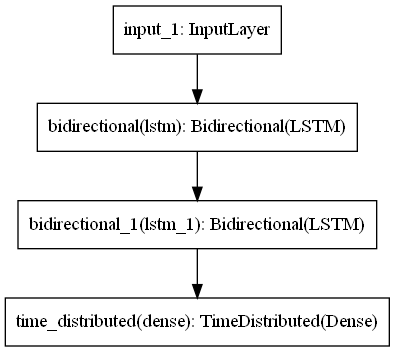

In [39]:
# # from tensorflow.keras.utils import plot_model
# import pydot_ng as pydot
# import pydotplus
# from pydotplus import graphviz

tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [40]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16, 1024)]        0         
_________________________________________________________________
bidirectional (Bidirectional (None, 16, 1024)          6295552   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16, 1024)          6295552   
_________________________________________________________________
time_distributed (TimeDistri (None, 16, 10)            10250     
Total params: 12,601,354
Trainable params: 12,601,354
Non-trainable params: 0
_________________________________________________________________


**Ensuring correct shape**

In [41]:
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
y_te = y_te.reshape(y_te.shape[0], y_te.shape[1], 1)

In [42]:
print(np.array(X_te).shape)
print(np.array(X_tr).shape)

(29, 16, 1024)
(174, 16, 1024)


**Model Training**

In [43]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(np.array(X_tr), y_tr, validation_data=(np.array(X_te), y_te),
                    batch_size=batch_size, epochs=10, verbose=1, callbacks=[callback])
# history = model.fit(np.array(embedding), y_tr, validation_data=(np.array(X_te), y_te),
#                     batch_size=batch_size, epochs=5, verbose=1)

Train on 174 samples, validate on 29 samples
Epoch 1/10
174/174 [==============================] - ETA: 0s - loss: 0.9677 - accuracy: 0.6897

D:\Sarika\NER\venv\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


174/174 [==============================] - 24s 138ms/sample - loss: 0.9677 - accuracy: 0.6897 - val_loss: 0.6375 - val_accuracy: 0.8642
Epoch 2/10
174/174 [==============================] - 17s 95ms/sample - loss: 0.5243 - accuracy: 0.8649 - val_loss: 0.4414 - val_accuracy: 0.8772
Epoch 3/10
174/174 [==============================] - 16s 94ms/sample - loss: 0.4241 - accuracy: 0.8728 - val_loss: 0.3551 - val_accuracy: 0.8728
Epoch 4/10
174/174 [==============================] - 16s 94ms/sample - loss: 0.3280 - accuracy: 0.8836 - val_loss: 0.2523 - val_accuracy: 0.9052
Epoch 5/10
174/174 [==============================] - 17s 95ms/sample - loss: 0.2174 - accuracy: 0.9454 - val_loss: 0.1506 - val_accuracy: 0.9634
Epoch 6/10
174/174 [==============================] - 16s 94ms/sample - loss: 0.1286 - accuracy: 0.9702 - val_loss: 0.0874 - val_accuracy: 0.9741
Epoch 7/10
174/174 [==============================] - 16s 95ms/sample - loss: 0.0793 - accuracy: 0.9820 - val_loss: 0.0606 - val_accur

In [44]:
hist = pd.DataFrame(history.history)

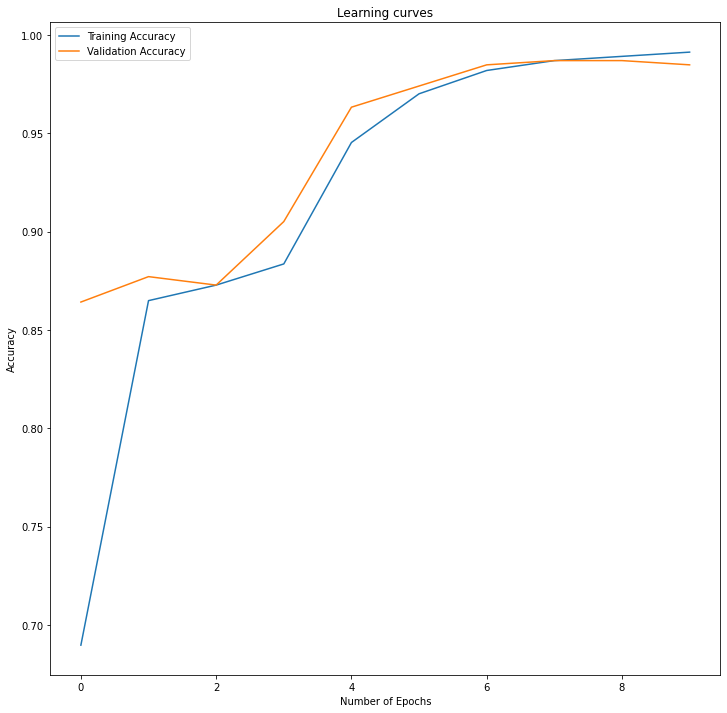

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Learning curves")
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.show()

**Printing results on test split**

In [46]:
i=0
p = model.predict(np.array(X_te[i:i+batch_size]))
p = np.argmax(p, axis=-1)

D:\Sarika\NER\venv\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [47]:
p.shape

(29, 16)

In [48]:
for X_te1, y_te1,p1 in zip(X_te,y_te.tolist(),p):
    for i,e in enumerate(embedding[0]):
        if e==X_te1:
            print("Sentence ", i)
            sentence = ""
#             c+=1
            for w, true, pred in zip(X[i], y_te1, p1):
                if w != "__PAD__":
                    sentence += " {} ({})".format(w,tags[pred])
#                 if w != "__PAD__" and tags[pred] == tags[true[0]]:
#                     print("{} : {} ({})".format(w,tags[pred], tags[true[0]]))
            print(sentence)

Sentence  120
 सिडनी (U-location) का (O) मौसम (O)
Sentence  72
 किधर (O) ज्यादा (O) ठंडी (U-weather_type) होगी (O) कसोल (U-location) या (O) मनाली (U-location)
Sentence  152
 आज (U-date) गर्मी (U-weather_type) ज्यादा (O) है (O) क्या (O)
Sentence  84
 कहा (O) मौसम (O) अच्छा (O) है (O) बेंगलोरे (U-location) या (O) गुड़गांव (U-location)
Sentence  66
 जौनपुर (U-location) कितना (O) ज्यादा (O) गर्म (U-weather_type) है (O) अभी (U-date) सूरत (U-location) से (O)
Sentence  178
 क्या (O) मैं (O) घर (O) के (O) रास्ते (O) पर (O) भीगने (O) वाला (O) हूं (O)
Sentence  5
 आज (U-date) बरसात (U-weather_type) की (O) संभावना (O) है (O) क्या (O)
Sentence  165
 और (O) कितना (O) गर्मी (U-weather_type) बढ़ेगा (O) और (O) यहाँ (O)
Sentence  2
 और (O) कितनी (O) बारिश (U-weather_type) होगी (O) यहाँ (O)
Sentence  37
 सर्दी (U-weather_type) कब (U-date) से (O) चालू (O) होगी (O) इस (B-date) बार (L-date)
Sentence  130
 आज (U-date) मौसम (O) का (O) क्या (O) हाल (O) है (O)
Sentence  126
 आज (U-date) के (O) लिए (O) मौसम (O) र

**Printing results on train split (29 samples)**

In [49]:
i = 0
p = model.predict(np.array(X_tr[i:i+batch_size]))
p = np.argmax(p, axis=-1)

In [50]:
for X_te1, y_te1,p1 in zip(X_tr,y_tr.tolist(),p):
    for i,e in enumerate(embedding[0]):
        if e==X_te1:
            print("Sentence ", i)
            sentence = ""
#             c+=1
            for w, true, pred in zip(X[i], y_te1, p1):
                if w != "__PAD__":
                    sentence += " {} ({})".format(w,tags[pred])
#                 if w != "__PAD__" and tags[pred] == tags[true[0]]:
#                     print("{} : {} ({})".format(w,tags[pred], tags[true[0]]))
            print(sentence)

Sentence  201
 मुंबई (U-location) में (O) बारिश (U-weather_type) होगी (O) क्या (O) आज (U-date)
Sentence  168
 क्या (O) कोटा (U-location) में (O) लू (U-weather_type) चल (O) रही (O) है (O)
Sentence  56
 कल (U-date) मौसम (O) कैसा (O) रहने (O) वाला (O) है (O)
Sentence  27
 क्या (O) बर्फ (U-weather_type) बरी (O) चालू (O) है (O) मनाली (U-location) में (O)
Sentence  113
 सबसे (O) ठंडी (U-weather_type) जगह (O) कौनसी (O) है (O) दुनिया (U-location) में (O)
Sentence  63
 बैंगलोर (U-location) ठंडा (U-weather_type) है (O) क्या (O) गुड़गांव (U-location) से (O)
Sentence  79
 पटना (U-location) कितना (O) डिग्री (O) ज्यादा (O) ठंडा (U-weather_type) है (O) सूरत (U-location) से (O)
Sentence  15
 क्या (O) बेंगलुरु (U-location) में (O) बारिश (U-weather_type) हो (O) रही (O) है (O)
Sentence  21
 क्या (O) बैंगलोर (U-location) में (O) हिमपात (U-weather_type) हो (O) रहा (O) है (O)
Sentence  7
 क्या (O) आज (U-date) जोरदार (O) बारिश (U-weather_type) होने (O) वाली (O) है (O) नागपुर (U-location) में (O)
Sentence  78

**Testing model on nervalweather.txt**

In [51]:
df = pd.DataFrame(columns=['Sentence #','Word','Tag'])

In [52]:
i=1
data = list()
with open(data_dir+'nervalweather.txt',encoding='utf-8') as f:
    for line in f.readlines():
        if line=='\n':
            i+=1
        else:
            data=line.split(" ")
            df=df.append({"Sentence #":f"Sentence {i}","Word":data[0],"Tag":re.sub("\n","",data[1])},ignore_index=True)
df

,Sentence #,Word,Tag
0,Sentence 1,आज,U-date
1,Sentence 1,मौसम,O
2,Sentence 1,कैसा,O
3,Sentence 1,है,O
4,Sentence 2,क्या,O
...,...,...,...
125,Sentence 21,रेणुकूट,U-location
126,Sentence 21,में,O
127,Sentence 21,मौसम,O
128,Sentence 21,कैसा,O


In [53]:
words = list(set(df["Word"].values))
words.append("ENDPAD")
n_words = len(words); n_words

57

In [54]:
getter = SentenceGetter(df)

In [55]:
sentences = getter.sentences

In [56]:
max_len = 16
tag2idx = {t: i for i, t in enumerate(tags)}

In [57]:
X_test = [[w[0] for w in s] for s in sentences]

In [58]:
new_X = []
for seq in X_test:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("__PAD__")
    new_X.append(new_seq)
X_test = new_X

In [59]:
y_test = [[tag2idx[w[1]] for w in s] for s in sentences]
y_test += y_test[0:8]
len(y_test)

29

In [60]:
from keras.preprocessing.sequence import pad_sequences
y_test = pad_sequences(maxlen=max_len, sequences=y_test, padding="post", value=tag2idx["O"])

In [61]:
print(len(X_test))
X_test += X_test[0:8]
print(len(X_test))

#making size = batch_size

21
29


In [62]:
embeds = elmo(batch_to_ids(X_test))

In [63]:
embedding = embeds["elmo_representations"]
# embedding

In [64]:
import torch
import tensorflow as tf

embedding1 = []
for t in embedding:
    np_tensor = t.detach().numpy()
    embedding1 += [np_tensor.tolist()]

embedding = embedding1

In [65]:
i = 0

p = model.predict(np.array(embedding[0]))
p = np.argmax(p, axis=-1)

In [66]:
p.shape

(29, 16)

In [67]:
y_test.shape

(29, 16)

In [68]:
for X_te1, y_te1,p1 in zip(embedding[0],y_test.tolist(),p):
    for i,e in enumerate(embedding[0]):
        if e==X_te1:
            print("Sentence ", i)
            sentence = ""
#             c+=1
            for w, true, pred in zip(X_test[i], y_te1, p1):
                if w != "__PAD__":
                    sentence += " {} ({})".format(w,tags[pred])
#                 if w != "__PAD__" and tags[pred] == tags[true[0]]:
#                     print("{} : {} ({})".format(w,tags[pred], tags[true[0]]))
            print(sentence)

Sentence  0
 आज (U-date) मौसम (O) कैसा (O) है (O)
Sentence  1
 आज (U-date) ज्यादा (O) ठंड (U-weather_type) है (O) क्या (O)
Sentence  2
 मनाली (U-location) में (O) कितनी (O) ठंडी (U-weather_type) है (O)
Sentence  3
 कोटा (U-location) ठंडा (U-weather_type) है (O) क्या (O) दिल्ली (U-location) से (O)
Sentence  4
 कोटा (U-location) में (O) ज्यादा (O) ठंडी (U-weather_type) है (O) क्या (O)
Sentence  5
 पठानकोट (U-location) और (O) दिल्ली (U-location) में (O) कहा (O) ज्यादा (O) गर्मी (U-weather_type) होगी (O)
Sentence  6
 दुनिया (U-location) की (O) सबसे (O) नमी (U-weather_type) वाली (O) जगह (O)
Sentence  7
 बनारस (U-location) और (O) गाजीपुर (U-location) में (O) कहां (O) ज्यादा (O) गर्मी (U-weather_type) पड़ेगा (O)
Sentence  8
 बनारस (U-location) और (O) गाजीपुर (U-location) में (O) कहां (O) ज्यादा (O) ठंड (U-weather_type) पड़ेगा (O)
Sentence  9
 बनारस (U-location) और (O) गाजीपुर (U-location) में (O) कहाँ (O) ज्यादा (O) जाड़ा (O) पड़ेगा (O)
Sentence  10
 इस (B-date) साल (L-date) जाड़ा (O) पड़ेगा (O) 

In [69]:
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from sklearn import metrics

print(metrics.classification_report(y_test.flatten(), p.flatten()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.90      1.00      0.95        28
           2       1.00      1.00      1.00         7
           4       1.00      0.92      0.96        25
           5       1.00      0.99      0.99       402
           7       1.00      1.00      1.00         1

    accuracy                           0.99       464
   macro avg       0.98      0.99      0.98       464
weighted avg       0.99      0.99      0.99       464



In [70]:
i = 0
p = model.predict(np.array(X_te).reshape(29,16,1024))
p = np.argmax(p, axis=-1)

In [71]:
print(metrics.classification_report(y_te.flatten(), p.flatten()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00        23
           2       0.78      1.00      0.88        14
           4       0.95      0.91      0.93        22
           5       0.99      0.99      0.99       401
           7       1.00      1.00      1.00         2

    accuracy                           0.98       464
   macro avg       0.95      0.98      0.97       464
weighted avg       0.99      0.98      0.99       464



In [72]:
i = 0
p = model.predict(np.array(X_tr).reshape(174,16,1024))
p = np.argmax(p, axis=-1)

In [73]:
print(metrics.classification_report(y_tr.flatten(), p.flatten()))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94        26
           1       0.97      0.99      0.98       140
           2       0.94      0.99      0.96        75
           3       0.00      0.00      0.00         1
           4       0.98      0.97      0.97       123
           5       1.00      1.00      1.00      2390
           6       0.00      0.00      0.00         1
           7       0.93      1.00      0.96        26
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1

    accuracy                           0.99      2784
   macro avg       0.57      0.59      0.58      2784
weighted avg       0.99      0.99      0.99      2784



D:\Sarika\NER\venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Sarika\NER\venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Sarika\NER\venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Saving model**

In [76]:
model_json = model.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model2.h5")